Nowadays, face recognition is done using Deep Learning algorithms such as Convolutional Neural Networks or Vision Transformers that achieves high state of the art accuracy. However, Deep Learning methods usually requires a large amount of dataset, numbering in the thousands to millions. Since we do not have access to this large amount of dataset, a better way is to use a simpler Machine Learning classification model such as NCC or KNNr. Since the models are simpler and not suitable to handle complex dataset such as photographs, we can first apply Principal Component Analysis to lower the dimensions of the images first. Then, once the eigenfaces are generated, we use these as training data. This will require less computational power and we can do it in a much shorter time. However, the accuracy will also be lower due to the information loss.

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import zipfile
from time import time
from sklearn import preprocessing
# Faces are stored in folders of zip file
# Respecive folders are named with members name
# Read face image from zip file 
shape=(100, 100)
faces = {}
# obtaining the images from zip file
# zip file is used because smaller size and more convenient to upload
with zipfile.ZipFile("sample_data/archive_new.zip") as zips:
    for filename in zips.namelist():
        if not filename.endswith(".pgm"):
            continue # not a face picture
        with zips.open(filename) as image:
            strang = filename.split('archive/')[1]
            # If we extracted files from zip, we can use cv2.imread(filename) instead
            # convert all images into np arrays
            read_image = cv2.imdecode(np.frombuffer(image.read(), np.uint8), cv2.IMREAD_GRAYSCALE)
            resized_image = cv2.resize(read_image, (shape[0], shape[1]))
            faces[strang] = np.array(resized_image)

faceshape = list(faces.values())[0].shape



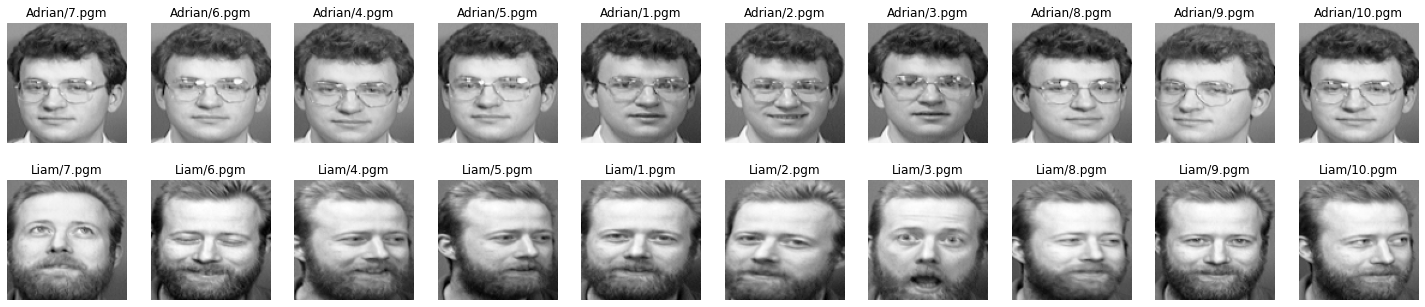

In [18]:
def plot_images(images, title, height, width, rows, columns):
    plt.figure(figsize=(2 * columns, 2 * rows))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=1.0, hspace=.20)

    for i in range(rows * columns):
        plt.subplot(rows, columns, i + 1)
        plt.imshow(images[i].reshape((height, width)), cmap=plt.cm.gray)
        plt.title(title[i])
        plt.axis('off')

faceimages = list(faces.values())[:] 
facetitles = list(faces.keys())[:]
# plotting sample images 
plot_images(faceimages, facetitles, 100, 100, 2, 10)


Text(0.5, 1.0, 'Sharpened')

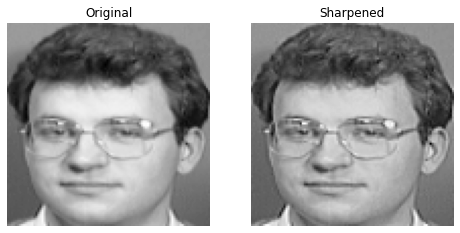

In [19]:
# preprocessing and sharpening image TEST
def sharpen_images(image, kernel_size=(5, 5), sigma=1.0, amount=1.0, threshold=0):
    """Return a sharpened version of the image, by applying CV sharpening operations."""
    blurred = cv2.GaussianBlur(image, kernel_size, sigma)
    sharpened = float(amount + 1) * image - float(amount) * blurred
    sharpened = np.maximum(sharpened, np.zeros(sharpened.shape))
    sharpened = np.minimum(sharpened, 255 * np.ones(sharpened.shape))
    sharpened = sharpened.round().astype(np.uint8)
    kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    im = cv2.filter2D(sharpened, -1, kernel)
    if threshold > 0:
        low_contrast_mask = np.absolute(image - blurred) < threshold
        np.copyto(sharpened, image, where=low_contrast_mask)
    return sharpened
# sharpened_image = unsharp_mask(faceimages[0])
sharpened_images = []

for i in range(len(faceimages)):
  sharpened_images.append(sharpen_images(faceimages[i]))
# comparing sharpened and unsharpened image
fig, axes = plt.subplots(1,2,sharex=True,sharey=True,figsize=(8,6))
axes[0].imshow(faceimages[0], cmap="gray")
axes[0].set_axis_off()
axes[0].set_title("Original")

axes[1].set_axis_off()
axes[1].imshow(sharpened_images[0], cmap="gray")
axes[1].set_title("Sharpened")



In [20]:
class PCA_scratch():
    """
    Implementing PCA based on Lecture Notes Chapter 1 
    First standardize the data by subtracting the mean of the matrix
    Then, find the covariance matrix based on the equation given in slides Obtain the eigenvalues and eigenvectors from the covariance matrix
    WARNING: This will take a lot of time because of the large 
    matrix multiplication (10000 x 10000). A better way is to use SVD
    After obtaining the eigenvalues and eigenvectors, sort it and select n_components of the first eigenvectors. This
    will be used to represent the eigenfaces.
    """

    def __init__(self, n_components=None, svd_compute=False,random_state=None, standardize=True):
        self.n_components = n_components
        self.svd_compute = svd_compute
        self.random_state = random_state
        self.standardize = standardize

    def standardize_data(self, images):
        # flatten images first
        self.straightened_image = np.resize(images, (self.num_images, shape[0] * shape[1]))
        # find the mean of the flattened image
        self.average_vector = np.sum(self.straightened_image, axis = 0, dtype='float64') / self.num_images 
        # make the flattened vector into matrix of shape image
        self.average_matrix = np.tile(self.average_vector, (self.num_images, 1))
        # print(self.average_matrix)
        # print(self.average_matrix.shape)
        # subtract the mean from the image
        self.centered_image = self.straightened_image - self.average_matrix 

        return self.centered_image

    def get_covariance_matrix(self, ddof=0):
        # calculate covariance matrix with standardized matrix A
        # C = self.centered_image.dot(self.centered_image.T) / self.num_images
        C = np.dot(self.centered_image.T, self.centered_image) / (self.num_images)
        # print(f'The shape of covariance is {C.shape}')
        return C
    def _svd_solver(self, X):
        U, S, V = np.linalg.svd(X.T,compute_uv=True)
        S = S**2
        return S, U

    def get_eigenvectors(self, C):
        # calculate eigenvalues & eigenvectors of covariance matrix 'C'
        if (self.svd_compute == True):
          self.eigenvalues, self.eigenvectors = self._svd_solver(self.centered_image)
        else:
          self.eigenvalues, self.eigenvectors = np.linalg.eig(C)

        self.eigen_pair = [(self.eigenvalues[index], self.eigenvectors[:,index]) for index in range(len(self.eigenvalues))]

        # sort eigenvalues descending and select columns based on n_components
        n_cols = np.argsort(self.eigenvalues)[::-1][:self.n_components]
        selected_vectors = self.eigenvectors[:, n_cols]
        return selected_vectors
    
    def get_cumulative_variance(self):
      self.eigen_pair.sort(reverse=True)

      sorted_eigenvalues  = [self.eigen_pair[index][0] for index in range(len(self.eigenvalues))]
      # can be removed lmfao, but check first 
      # sorted_eigenvectors = [self.eigen_pair[index][1] for index in range(len(self.eigenvalues))]
      self.explained_variance_ratio = np.real(np.cumsum(sorted_eigenvalues)/sum(sorted_eigenvalues))

      # Show cumulative proportion of varaince with respect to components
      # print("Cumulative proportion of variance explained vector: \n%s" %self.explained_variance_ratio)

      # x-axis for number of principal components kept
      num_comp = range(1,len(sorted_eigenvalues)+1)

      plt.figure(figsize=(20, 20))

      plt.title('Variance Explained Ratio against Number of Principal Components')

      plt.xlabel('Principal Components')

      plt.ylabel('Cumulative Variance Explained Ratio')

      plt.xticks(np.arange(0, faceshape[0] * faceshape[1], 250.0))


      plt.scatter(num_comp, self.explained_variance_ratio)
      plt.show()

    def project_matrix(self, eigenvectors):
        P = np.dot(self.centered_image, eigenvectors)
        return P

    def fit(self, images):
        self.images_copy = images.copy()
        self.num_images = len(images)
        # straighten the image first into M(shape[0]) x N(shape[1]) column vector
        self.centered_image = self.standardize_data(images)
        
        # obtaining the covariance matrix 
        self.cov_mat = self.get_covariance_matrix()
        
        self.eigenvectors = self.get_eigenvectors(self.cov_mat)

        self.projected_components = self.project_matrix(self.eigenvectors)

        # the computation generates complex values hmm 
        self.projected_components = np.real(self.projected_components)

        self.eigvec_C = self.centered_image.T @ self.projected_components
        
        self.eigenfaces = preprocessing.normalize(self.eigvec_C.T)
        # can also return all 10000 projected components
        # then let the user choose 200 of it after viewing the graph 
        return self.projected_components

    def fit_transform(self, X):
      self.weights = self.eigenfaces @ (self.images_copy - self.average_vector).T
      self.normalized_matrix = np.tile(pca.average_vector, (len(X), 1))
      X_transformed = self.eigenfaces @ (X - self.normalized_matrix).T
      return X_transformed


    def plot_mean_image(self):
        plt.imshow(np.resize(self.average_vector, (shape[0], shape[1])), cmap='gray')
        plt.title('Mean Image')
        plt.show()

    # plots a number of eigenfaces for visualization
    def plot_eigenfaces(self):
        labels = [i for i in range(10)]
        plot_images(self.eigenfaces, labels, 100, 100, 2, 5)


In [21]:
X_facetrain = []
Y_facetrain = []
X_facetest = []
Y_facetest = []
facematrix = []
facelabel=[]
# taking in dataset,

for key, val in faces.items():
    # preprocess the image
    val = sharpen_images(val)
    if key.startswith("test"):
        X_facetest.append(val.flatten())
        folder_name = key.split('/')[1].rsplit('.')[0].rsplit('_')[0]
        Y_facetest.append(folder_name)
        continue

    X_facetrain.append(val.flatten())
    Y_facetrain.append(key.split('/')[0])
    facematrix.append(val)
    facelabel.append(key.split("/")[0])



In [22]:
facematrix = np.array(facematrix)
X_facetrain = np.array(X_facetrain)

pca = PCA_scratch(n_components=300, svd_compute=True)
t0 = time()
X_train_pca = pca.fit(X_facetrain)
print(f'Time elapsed for PCA compression: %0.3fs' % (time() - t0))

Time elapsed for PCA compression: 27.749s


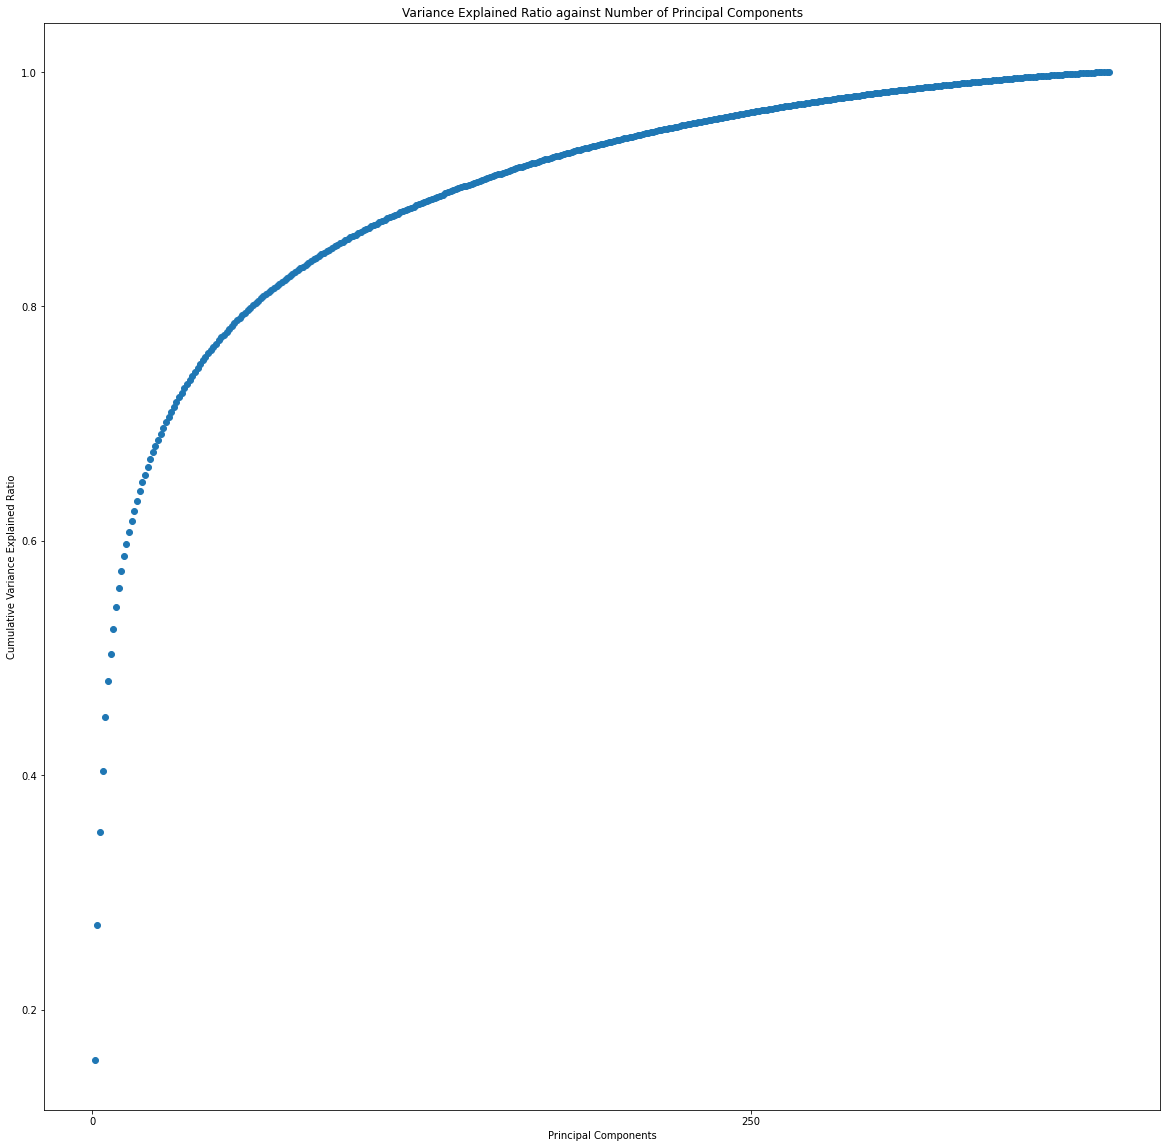

Number of principal components needed to achieve 95% variance: 214


In [23]:
pca.get_cumulative_variance()
print(f'Number of principal components needed to achieve 95% variance: {sum(pca.explained_variance_ratio < 0.95)}')

Mean eigenface


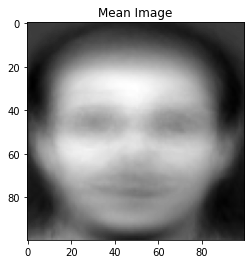

In [24]:
print('Mean eigenface')
pca.plot_mean_image()

Generated eigenfaces


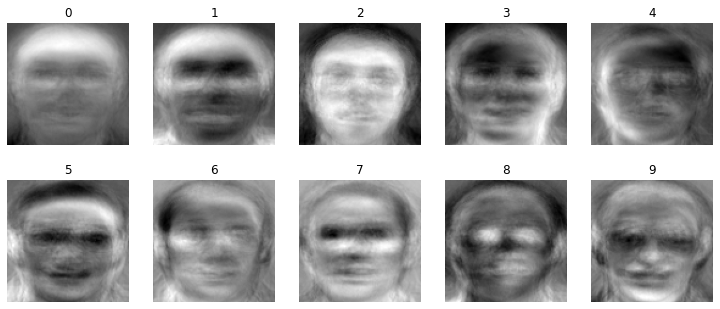

In [25]:
print('Generated eigenfaces')
pca.plot_eigenfaces()

Nearest match Oliver with Euclidean distance 2374.332460
Predicted: Oliver
Expected: Oliver


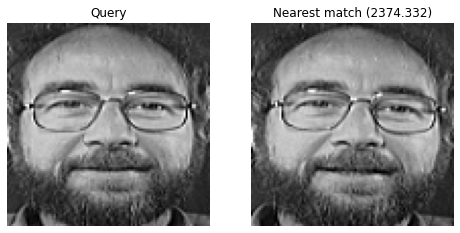

Nearest match Oliver with Euclidean distance 1467.514490
Predicted: Oliver
Expected: Oliver


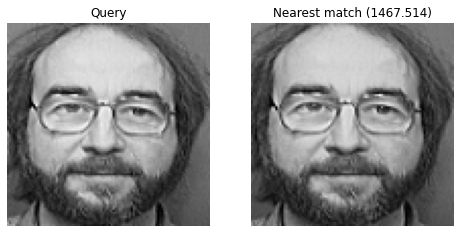

Nearest match Peter with Euclidean distance 3229.895892
Predicted: Peter
Expected: Peter


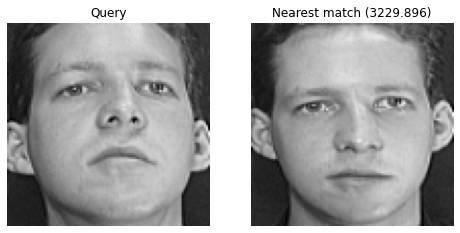

Nearest match Benjamin with Euclidean distance 2049.284580
Predicted: Benjamin
Expected: Benjamin


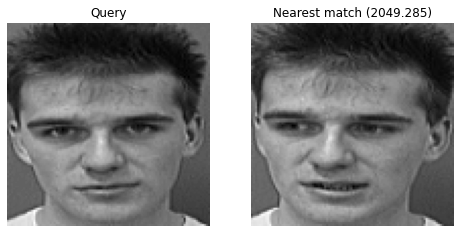

Nearest match Peter with Euclidean distance 3487.784406
Predicted: Peter
Expected: Peter


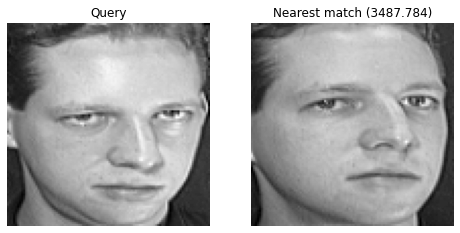

Nearest match Benjamin with Euclidean distance 1899.222228
Predicted: Benjamin
Expected: Benjamin


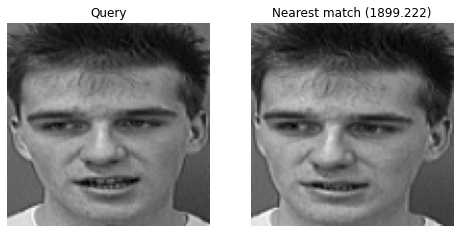

Nearest match Maxus with Euclidean distance 3676.889939
Predicted: Maxus
Expected: Maxus


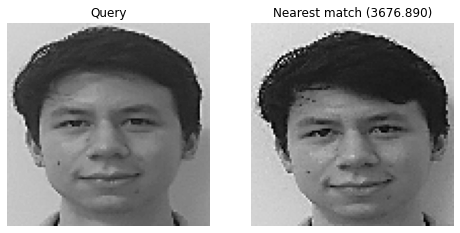

Nearest match Unknown with Euclidean distance 7245.645228
Predicted: Unknown
Expected: Unknown


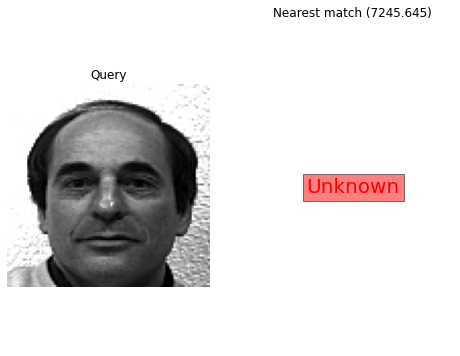

Nearest match Maxus with Euclidean distance 5007.551729
Predicted: Maxus
Expected: Maxus


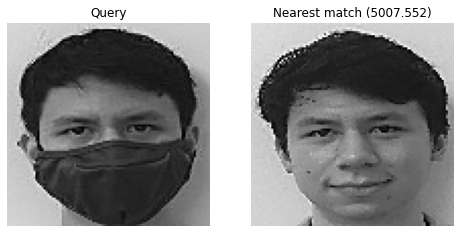

Nearest match Maxus with Euclidean distance 5444.639261
Predicted: Maxus
Expected: Maxus


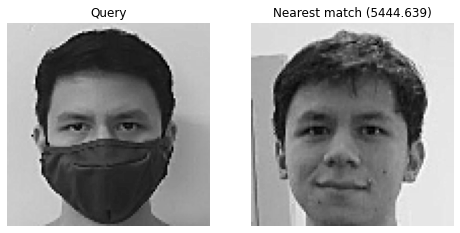

In [36]:
# Transform the X_facetest data with PCA(based on X_facetrain)
X_facetest_pca = pca.fit_transform(X_facetest)

for i in range(10):
    euclid = np.linalg.norm(pca.weights - X_facetest_pca.T[i].reshape(-1, 1), axis = 0)
    nearest_match = np.argmin(euclid)
    fig, axes = plt.subplots(1,2,sharex=True,sharey=True,figsize=(8,6))
    axes[0].set_axis_off()
    axes[0].imshow(X_facetest[i].reshape(faceshape), cmap="gray")
    axes[0].set_title("Query")
    if (euclid[nearest_match] < 6000):
      print("Nearest match %s with Euclidean distance %f" % (facelabel[nearest_match], euclid[nearest_match]))
      print(f'Predicted: {facelabel[nearest_match]}')
      print(f'Expected: {Y_facetest[i]}')
      axes[1].set_axis_off()
      axes[1].imshow(facematrix[nearest_match].reshape(faceshape), cmap="gray")
      title = 'Nearest match (%.3f)' % (euclid[nearest_match])
      axes[1].set_title(title)
    else:
      print("Nearest match Unknown with Euclidean distance %f" %  euclid[nearest_match])
      print(f'Predicted: Unknown')
      print(f'Expected: {Y_facetest[i]}')
      axes[1].set_title("Nearest match")
      axes[1].set_axis_off()
      title = 'Nearest match (%.3f)' % (euclid[nearest_match])
      axes[1].set_title(title)
      axes[1].text( s='Unknown',
        horizontalalignment='center',
        verticalalignment='center',
        fontsize=20, color='red',
        x=50, y=50,
        bbox=dict(facecolor='red', alpha=0.5)
        )
    plt.show()

Below shows a comparison between the transformed values from our PCA implemented from scratch and the PCA from sklearn library. When we compare the beginning values, we see most are equal, but some of the values in the eigenvector have opposite signs. What does it mean when the vector is negative? If 𝐱 is an eigenvector of the matrix 𝐀 then 𝐀𝐱=𝜆𝐱 for some 𝜆. But then 𝐴(−𝐱)=−𝐴𝐱=𝜆(−𝐱) so −𝐱 is also an eigenvector. Hence, the signs of eigenvectors can actually be positive or negative as long as the values are the same. However, when we compare the end values, we see that there is a big difference. This is most probably because a different eigenvectors has been chosen at the end.

In [ ]:
from sklearn.decomposition import PCA

n_components=300
weights = pca.eigenfaces @ (X_facetrain - pca.average_vector).T
pca_sk = PCA(n_components).fit(X_facetrain)
X_train_another_pca = pca_sk.transform(X_facetrain)
X_test_another_pca = pca_sk.transform(X_facetest)

print('Transformation of self implemented PCA on X_train_pca:')
print(f'Shape of the matrix: {X_train_pca.shape}')
print(X_train_pca)
print('\nTransformation of sklearn PCA on X_train_pca:')
print(f'Shape of the matrix: {X_train_another_pca.shape}')
print(X_train_another_pca)

Transformation of self implemented PCA on X_train_pca:
Shape of the matrix: (381, 300)
[[ 5.76118999e+01  3.68878133e+03 -1.76432248e+03 ... -4.56565994e+01
   9.48220059e+00  3.36626883e+00]
 [-7.49349575e+02  3.10630359e+03 -2.22660068e+02 ...  1.95926192e+01
   1.02616894e+02 -3.53082575e+01]
 [-2.32931009e+02  3.23997335e+03 -9.96839167e+02 ... -1.91932497e+01
   1.88226811e+01 -3.45895995e+01]
 ...
 [-1.64737231e+03 -1.96486946e+03 -2.00497278e+02 ... -2.65414085e+01
  -1.21651800e+01  1.02554767e+02]
 [-1.34767732e+03 -1.57655223e+03 -3.19845152e+02 ...  3.05511079e+01
  -7.50606572e+01  6.17428211e+00]
 [-1.08623672e+03 -1.72621850e+03  8.54487484e+01 ... -1.51433583e+02
   1.80541495e+02 -9.92272183e+01]]

Transformation of sklearn PCA on X_train_pca:
Shape of the matrix: (381, 300)
[[ 5.76118999e+01  3.68878133e+03 -1.76432248e+03 ...  2.79441764e+01
  -1.49365743e+01 -3.66993310e+00]
 [-7.49349575e+02  3.10630359e+03 -2.22660068e+02 ... -2.13246890e+01
   1.55403931e+01  1.00

As a comparison, we will now perform Deep Learning on the face datasets. The Deep Learning algorithm used will be a Convolutional Neural Network, a neural network widely used for image recognition and image classification problems.

In [2]:
# Deep Learning(Convolutional Neural Network)
from numpy import expand_dims
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from keras.models import Sequential
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder 
from keras.models import load_model
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import Normalizer
from sklearn.neighbors import KNeighborsClassifier

def resize_picture_RGB(filename, required_size = (160, 160)):
  read_image = cv2.imdecode(np.frombuffer(filename.read(), np.uint8), cv2.IMREAD_COLOR)
  resized_image = cv2.resize(read_image, required_size)
  face_array = np.array(resized_image)
  return face_array

def resize_picture(filename, required_size = (160, 160)):
  read_image = cv2.imdecode(np.frombuffer(filename.read(), np.uint8), cv2.IMREAD_GRAYSCALE)
  resized_image = cv2.resize(read_image, required_size)
  face_array = np.array(resized_image)
  return face_array

X_train = []
y_train = []
X_test = []
y_test = []

def data_load(path, color=False):
	with zipfile.ZipFile(path) as zips:
		for filename in zips.namelist():		
			if not filename.endswith('.pgm'):
				continue
			if not filename.startswith('archive/test'):
				with zips.open(filename) as image:
					if (color == True):
						X_train.append(resize_picture_RGB(image))
					else:
						X_train.append(resize_picture(image))
					strang = filename.split('archive/')[1]
					folder_name = strang.rsplit('/')[0]
					y_train.append(folder_name)
			if filename.startswith('archive/test'):
				with zips.open(filename) as image:
					strang = filename.split('archive/')[1]
					folder_test_name = strang.split('/')[1].rsplit('.')[0].rsplit('_')[0]
					y_test.append(folder_test_name)
					if (color == True):
						X_test.append(resize_picture_RGB(image))
					else:
						X_test.append(resize_picture(image))
		 

ModuleNotFoundError: No module named 'keras'

In [31]:
data_load('sample_data/archive_new_neural.zip', color=False)
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

X_train = X_train.reshape(X_train.shape[0], 160, 160, 1)
X_test = X_test.reshape(X_test.shape[0], 160, 160, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')


# normalizing the data to help with the training
X_train /= 255
X_test /= 255

label_encoder = LabelEncoder()
n_classes=40
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)
y_train = np_utils.to_categorical(y_train, n_classes)
y_test = np_utils.to_categorical(y_test, n_classes)


model = Sequential()
# convolutional layer
model.add(Conv2D(25, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu', input_shape=(160,160,1)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
# hidden layer
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.3))
# output layer
model.add(Dense(40, activation='softmax'))

# compiling the sequential model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 158, 158, 25)      250       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 79, 79, 25)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 79, 79, 25)        0         
                                                                 
 flatten (Flatten)           (None, 156025)            0         
                                                                 
 dense (Dense)               (None, 200)               31205200  
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                        

In [32]:
result = model.fit(X_train, y_train, batch_size=128, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
4/4 [==============================] - 10s 2s/step - loss: 10.4006 - accuracy: 0.0389 - val_loss: 4.5667 - val_accuracy: 0.0000e+00
Epoch 2/10
4/4 [==============================] - 7s 2s/step - loss: 7.6227 - accuracy: 0.0259 - val_loss: 3.7717 - val_accuracy: 0.0000e+00
Epoch 3/10
4/4 [==============================] - 7s 2s/step - loss: 5.5503 - accuracy: 0.0285 - val_loss: 3.9122 - val_accuracy: 0.0000e+00
Epoch 4/10
4/4 [==============================] - 7s 2s/step - loss: 4.2250 - accuracy: 0.0207 - val_loss: 3.8393 - val_accuracy: 0.0000e+00
Epoch 5/10
4/4 [==============================] - 7s 2s/step - loss: 3.9448 - accuracy: 0.0207 - val_loss: 3.7299 - val_accuracy: 0.0000e+00
Epoch 6/10
4/4 [==============================] - 8s 2s/step - loss: 3.6718 - accuracy: 0.0233 - val_loss: 3.7136 - val_accuracy: 0.0000e+00
Epoch 7/10
4/4 [==============================] - 9s 2s/step - loss: 3.6757 - accuracy: 0.0311 - val_loss: 3.7182 - val_accuracy: 0.0000e+00
Epoch 8/10


Graph of Train Loss and Validation Loss


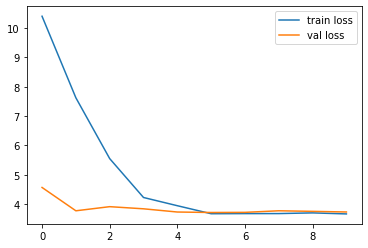

Graph of Train Accuracy and Validation Accuracy


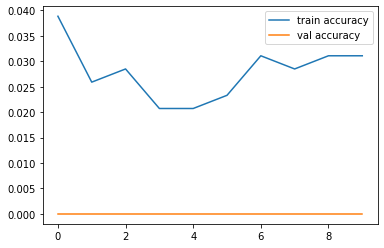

In [33]:
print('Graph of Train Loss and Validation Loss')
plt.plot(result.history['loss'], label='train loss')
plt.plot(result.history['val_loss'], label='val loss')
plt.legend()
plt.show()

print('Graph of Train Accuracy and Validation Accuracy')
plt.plot(result.history['accuracy'], label='train accuracy')
plt.plot(result.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.show()

As shown in the results obtained above, the performance of our Convolutional Neural Network model is terrible. This is due to the low amount of data, given which is unsuitable for Deep Learning methodologies(cite unreasonable effectiveness of data). A recommended practice is to instead have 10,000 training data per class, or in this case 10,000 face per person. This is practically impossible for us. Instead, a better approach to deep learning on small image datasets is
to use a pretrained model. In our situation, a pretrained model is a model that was previously trained on a large dataset, typically on a large-scale image-classification task. If this original model is trained on a general and large enough dataset, it can maintain the spatial heirarchy of features of learned and act as a generic model for recognising all types of faces. Hence, its features can prove useful for many different computer vision problems that involves faces, even though these new problems may involve completely different faces or classes than those
of the original task. In this case, we will be using FaceNet, a ResNet-Inception Deep Learning model trained on 1 million celebrity face images. The pretrained FaceNet model is provided by Hiroki Tanai at [Keras FaceNet PreTrained Model (92.3 MB)](https://drive.google.com/drive/folders/1pwQ3H4aJ8a6yyJHZkTwtjcL4wYWQb7bn). Even though FaceNet is initially trained on colored images, it is assumed that it will work with our grayscale images due to the facial features already learned in the model.

In [64]:
X_train = []
y_train = []
X_test = []
y_test = []
data_load('sample_data/archive_new_neural.zip', color=True)
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(386, 160, 160, 3) (386,) (9, 160, 160, 3) (9,)


In [66]:
model = load_model('sample_model/facenet_keras.h5')
print('Loaded Model')
model.summary()

Loaded Model
Model: "inception_resnet_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv2d_1a_3x3 (Conv2D)         (None, 79, 79, 32)   864         ['input_1[0][0]']                
                                                                                                  
 Conv2d_1a_3x3_BatchNorm (Batch  (None, 79, 79, 32)  96          ['Conv2d_1a_3x3[0][0]']          
 Normalization)                                                                                   
                                                                   

In [67]:
# converting the images so that it can be predicted
# by the models 
# FaceNet requires standardized images of color,
# with each of them having dimensions of (1, 160, 160, 3) 
def transform_embedding(model, face_pixels):
	# scale pixel values
	face_pixels = face_pixels.astype('float32')
	# standardize pixel values across channels (global)
	mean, std = face_pixels.mean(), face_pixels.std()
	
	face_pixels = (face_pixels - mean) / std
	# add dimension to transform array into
	# batch of a single sample, shape is (1, 160, 160, 3)
	# this can then be fed into FaceNet model
	samples = expand_dims(face_pixels, axis=0)
	# return the prediction of the model
	yhat = model.predict(samples)
	return yhat[0]

In [68]:
X_train_transformed = []
for face_pixels in X_train:
	embedding = transform_embedding(model, face_pixels)
	X_train_transformed.append(embedding)
X_train_transformed = np.array(X_train_transformed)
print(X_train_transformed.shape)
# convert each face in the test set to an embedding
X_test_transformed = []
for face_pixels in X_test:
	embedding = transform_embedding(model, face_pixels)
	X_test_transformed.append(embedding)
X_test_transformed = np.array(X_test_transformed)
print(X_test_transformed.shape)

(386, 128)
(9, 128)


In [69]:
# obtain the number of training data and test data
print('Dataset: train=%d, test=%d' % (X_train_transformed.shape[0], X_test_transformed.shape[0]))
in_encoder = Normalizer(norm='l2')
X_train_transformed = in_encoder.transform(X_train_transformed)
X_test_transformed = in_encoder.transform(X_test_transformed)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(y_train)
y_train = out_encoder.transform(y_train)
y_test = out_encoder.transform(y_test)
# feed the FaceNet transformed face embeddings
# into KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_train_transformed, y_train)
# carry out predictions
yhat_train = model.predict(X_train_transformed)
yhat_test = model.predict(X_test_transformed)
# calculate score
score_train = accuracy_score(y_train, yhat_train)
score_test = accuracy_score(y_test, yhat_test)
# summarize
print(f'Train Accuracy: {score_train * 100}%')
print(f'Test Accuracy: {score_test * 100}%')

Dataset: train=386, test=9
Train Accuracy: 100.0%
Test Accuracy: 100.0%


Predicted: Oliver (100.00)
Expected: Oliver


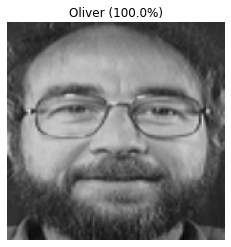

Predicted: Oliver (100.00)
Expected: Oliver


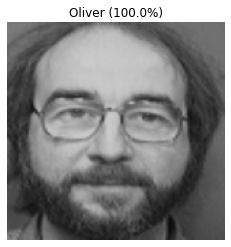

Predicted: Peter (100.00)
Expected: Peter


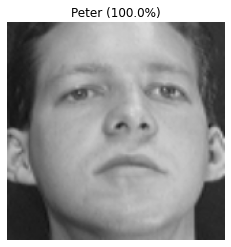

Predicted: Benjamin (100.00)
Expected: Benjamin


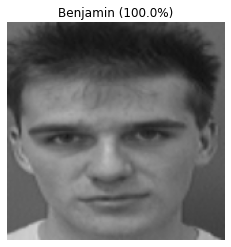

Predicted: Peter (100.00)
Expected: Peter


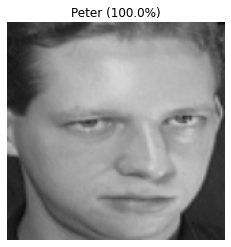

Predicted: Benjamin (100.00)
Expected: Benjamin


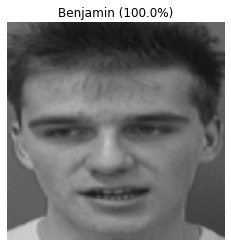

Predicted: Maxus (100.00)
Expected: Maxus


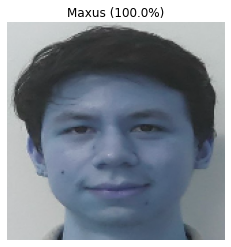

Predicted: Maxus (100.00)
Expected: Maxus


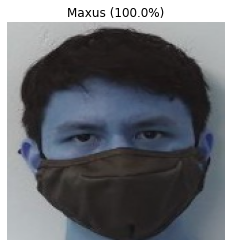

Predicted: Maxus (100.00)
Expected: Maxus


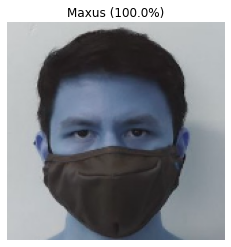

In [70]:
for i in range(X_test.shape[0]):
  face_pixels = X_test[i]
  face_embeddings = X_test_transformed[i]
  face_class = y_test[i]
  face_name = out_encoder.inverse_transform([face_class])
  # prediction for the face
  samples = expand_dims(face_embeddings, axis=0)
  # predicted y from neural network model
  yhat_class = model.predict(samples)
  yhat_prob = model.predict_proba(samples)
  # get the name of faces from the prediction
  class_index = yhat_class[0]
  class_probability = yhat_prob[0,class_index] * 100
  predict_names = out_encoder.inverse_transform(yhat_class)
  print('Predicted: %s (%.2f)' % (predict_names[0], class_probability))
  print('Expected: %s' % face_name[0])
  # plot for fun
  plt.imshow(face_pixels)
  plt.axis('off')
  title = f'{predict_names[0]} ({class_probability}%)'
  plt.title(title)
  plt.show()